This is a development notebook with the purpose of creating code that more efficiently generates black holes along various lines of sight in the Milky Way. Some of this is modified code from synthetic.py (commit d9dee2f).

In [1]:
import numpy as np
import astropy.coordinates as coord
from astropy import units
from scipy import interpolate, integrate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Default inputs coped from function call
fdm=1
pbh_mass=40
r_max=8.3
c=12.94 # Concentration index.
r_vir=200
inner_slope=.5
v_esc=550
overwrite=False
seed=None

In [3]:
#Define parameters for NFW profile calculations
r_s = r_vir/c #kpc, scale radius
g = 4.3*(10**-3) #(pc*km^2)/(Msun*s^2)
h = 70 #km/(s*Mpc)

In [4]:
#Obtain survey area and center latitude and longitude
# b = float(ebf_log['latitude'])
# l = float(ebf_log['longitude'])
# surveyArea = float(ebf_log['surveyArea'])
# just hard coding some number for testing purposes
b = 0.5 * np.pi / 180 # rad
l = -0.5 * np.pi / 180 # rad
surveyArea = 0.0001 # deg**2

In [5]:
#Calculate the size of the field of view we are running
field_of_view_radius = (surveyArea/np.pi)**(1/2) # deg
print('{0:0.5f} [deg]'.format(field_of_view_radius))

0.00564 [deg]


In [6]:
def rho_dmhalo(r, rho_0=0.0106, r_s=19, gamma=1):
    """
    Density profile of the dark matter halo.
    We are using the parametrization from McMillan (2017) Equation 5,
    with defaults based on the mean values in Table 2.
    r: galactocentric radius [units: kpc]
    rho_0: characteristic density in [units: m_sun / pc**3]
    r_s: scale radius in [units: kpc]
    gamma: gamma=1 for NFW, gamma > 1 cuspy, gamma < 1 cored
    
    returns: density at r [units: m_sun / pc**3]
    """
    x = r / r_s
    rho = rho_0 / (x**gamma * (1 + x)**(3 - gamma))
    return rho

In [7]:
# Maximum line of sight distance to consider for PBH injection
# heliocentric coordinate radius [units: kpc]
r_h_max = 20

In [8]:
# Generate an array of heliocentric radii
# These radii will just be used to numerically integrate the density
n_lin = 1000
if np.logical_and(np.logical_and(np.abs(l)<0.5 * np.pi / 180, 
                                 np.abs(b)<0.5 * np.pi / 180),
                  n_lin<100000):
    print('Warning: for fields very near the center of the Milky Way it is reocmmended that the number of elements used to estimate the density be n_lin>100000')
r_h_linspace = np.linspace(0, r_h_max, num=n_lin)

In [9]:
# Represent the line of sight line in galactic coordinates
galactic_lin = coord.Galactic(l=l * units.rad,
                              b=b * units.rad,
                              distance=r_h_linspace * units.kpc)

In [10]:
print(galactic_lin.b.deg)
print(galactic_lin.l.deg)
print(galactic_lin.distance.kpc)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.

In [11]:
# convert the line of sight to galactocentric coordinates
#outputs l, b, and distance in degrees.
galactocen_lin = galactic_lin.transform_to(coord.Galactocentric(representation_type='spherical'))


Create some diagnostic plots to make sure the coordinates are doing what we think they should.

(0, 12.280993073650272)

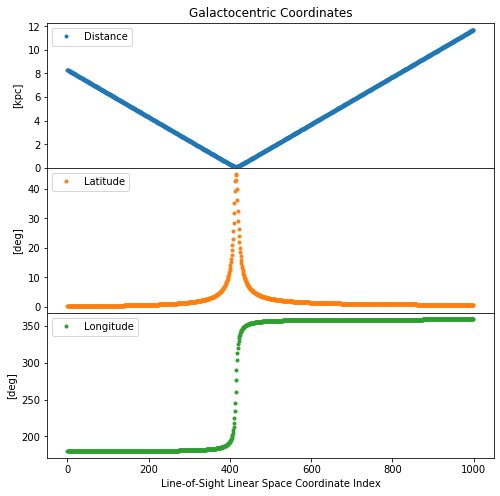

In [12]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(galactocen_lin.spherical.distance, '.', label='Distance', c='C0')
axs[1].plot(galactocen_lin.spherical.lat.deg, '.', label='Latitude', c='C1')
axs[2].plot(galactocen_lin.spherical.lon.deg, '.', label='Longitude',c='C2')

plt.legend(loc='best')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

axs[0].set_title('Galactocentric Coordinates')
axs[0].set_ylabel('[kpc]')

axs[1].set_ylabel('[deg]')

axs[2].set_ylabel('[deg]')
axs[2].set_xlabel('Line-of-Sight Linear Space Coordinate Index')

axs[0].set_ylim(0, axs[0].set_ylim()[1])

(0, 12.280993073650272)

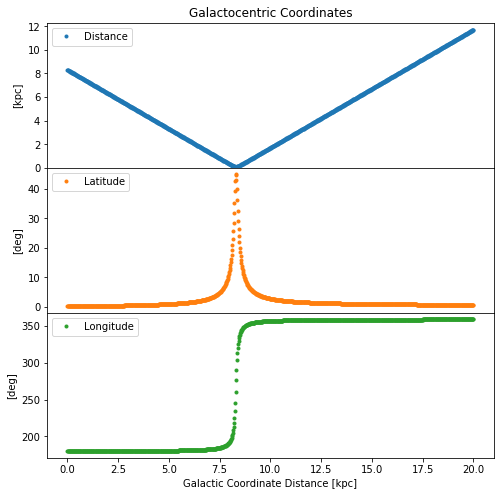

In [13]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(8,8))
axs[0].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.distance, '.', label='Distance', c='C0')
axs[1].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.lat.deg, '.', label='Latitude', c='C1')
axs[2].plot(galactic_lin.distance.kpc,
            galactocen_lin.spherical.lon.deg, '.', label='Longitude',c='C2')

plt.legend(loc='best')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

axs[0].set_title('Galactocentric Coordinates')
axs[0].set_ylabel('[kpc]')

axs[1].set_ylabel('[deg]')

axs[2].set_ylabel('[deg]')
axs[2].set_xlabel('Galactic Coordinate Distance [kpc]')

axs[0].set_ylim(0, axs[0].set_ylim()[1])

Determine the dark matter density at all galactocentric radii along the line of sight.

In [14]:
# Determine the dark matter density at all galactocentric radii along the line of sight.
rho_lin = rho_dmhalo(galactocen_lin.spherical.distance.value,
                     rho_0=0.0106, r_s=19, gamma=1)

Text(0.5, 0, 'Line-of-Sight Linear Space Coordinate Index')

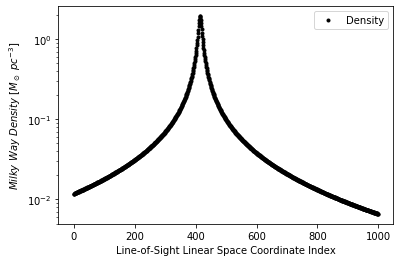

In [15]:
plt.semilogy(rho_lin, '.', label='Density',c='k')
plt.legend(loc='best')
plt.ylabel('$Milky\ Way\ Density\ [M_\odot\ pc^{-3}]$')
plt.xlabel('Line-of-Sight Linear Space Coordinate Index')

(0, 21.0)

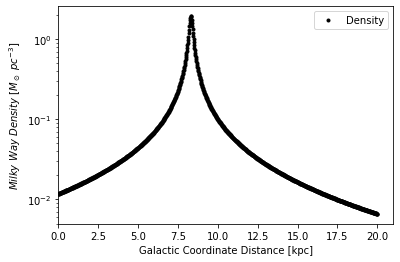

In [16]:
plt.semilogy(galactic_lin.distance.kpc,
             rho_lin, '.', label='Density',c='k')
plt.legend(loc='best')
plt.ylabel('$Milky\ Way\ Density\ [M_\odot\ pc^{-3}]$')
plt.xlabel('Galactic Coordinate Distance [kpc]')
plt.xlim(0, plt.xlim()[1])

(0, 12.280993073650272)

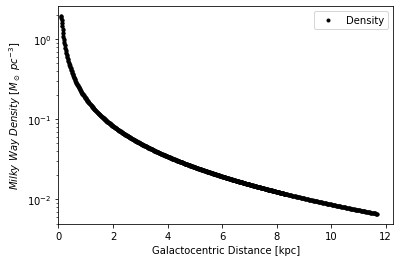

In [17]:
plt.semilogy(galactocen_lin.spherical.distance.value,
             rho_lin, '.', label='Density',c='k')
plt.legend(loc='best')
plt.ylabel('$Milky\ Way\ Density\ [M_\odot\ pc^{-3}]$')
plt.xlabel('Galactocentric Distance [kpc]')
plt.xlim(0, plt.xlim()[1])

In [18]:
# Estimate the total mass within the line-of-sight cylinder [units: M_sun kpc**-2]
rho_marg_r = np.trapz(rho_lin, dx=r_h_max / n_lin) * 1000**3
print("Linear density along line-of-sight = {0:0.2e} [M_sun kpc**-2]".format(rho_marg_r))
# LOS cylinder radius in kpc, assuming small angle approximation [units: kpc]
r_proj_los_cyl = field_of_view_radius * np.pi / 180 * r_h_max
# Projected area of the LOS cylinder [units: kpc**2]
area_proj_los_cyl = np.pi * r_proj_los_cyl**2
# Mass within the total cylinder
mass_los_cyl = rho_marg_r * area_proj_los_cyl
print("Mass within line-of-sight cylinder = {0:0.2e} [M_sun]".format(mass_los_cyl))

Linear density along line-of-sight = 1.81e+09 [M_sun kpc**-2]
Mass within line-of-sight cylinder = 2.20e+04 [M_sun]


(0, 21.0)

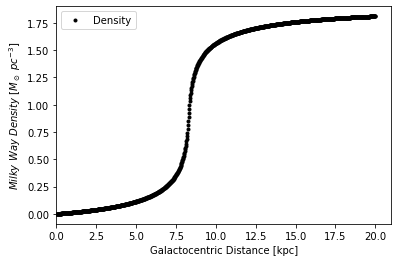

In [19]:
plt.plot(galactic_lin.distance.kpc,
             np.cumsum(rho_lin)*r_h_max / n_lin, '.', label='Density',c='k')
plt.legend(loc='best')
plt.ylabel('$Milky\ Way\ Density\ [M_\odot\ pc^{-3}]$')
plt.xlabel('Galactocentric Distance [kpc]')
plt.xlim(0, plt.xlim()[1])

In [20]:
# Total number of black holes to randomly draw
n_pbh = int(np.round(fdm * mass_los_cyl / pbh_mass))
print('Number of PBH to populate LOS cylinder with = {0}'.format(n_pbh))

Number of PBH to populate LOS cylinder with = 551


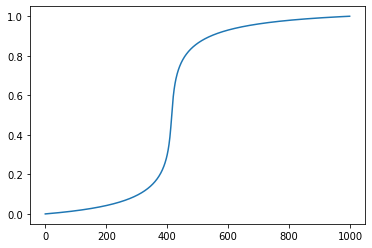

In [21]:
# Estimate the discrete CDF based on the discrete PDF
# cdf_los = np.cumsum(rho_lin) / np.sum(rho_lin)
rho_marg_r_cum = integrate.cumtrapz(y=rho_lin,
                                          x=galactic_lin.distance.kpc,
                                          dx=r_h_max / n_lin)
cdf_los = rho_marg_r_cum / rho_marg_r_cum[-1]
# Since cumtrapz does not include zero for the first element insert it
cdf_los = np.insert(cdf_los,0,0)
plt.plot(cdf_los)

In [22]:
# Verify correct size
print(np.size(cdf_los))
print(np.size(galactic_lin.distance.kpc))

1000
1000


In [23]:
# Create a function to interpolate the CDF so that we can randomly sample from it
f_cdf_d = interpolate.interp1d(cdf_los,
                               galactic_lin.distance.kpc)

In [24]:
x = np.linspace(0,1,100)
y = f_cdf_d(x)

Text(0, 0.5, 'Galactic Coordinate Distance along LOS [kpc]')

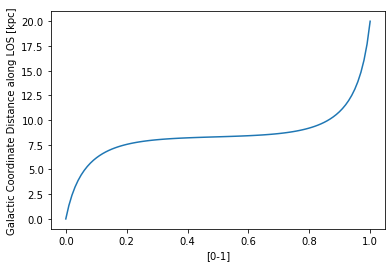

In [25]:
plt.plot(x, y)
plt.xlabel('[0-1]')
plt.ylabel('Galactic Coordinate Distance along LOS [kpc]')

In [26]:
d_galac = f_cdf_d(np.random.uniform(size=n_pbh))

(array([  1.,   3.,   2.,   5.,   1.,   3.,   1.,   6.,   7.,   2.,   8.,
          3.,   6.,   6.,   7.,  14.,  21.,  30.,  50., 139.,  84.,  29.,
         13.,  20.,   8.,   6.,   7.,   5.,   5.,   6.,   7.,   5.,   7.,
          2.,   3.,   4.,   3.,   2.,   3.,   2.,   1.,   0.,   3.,   1.,
          2.,   0.,   3.,   1.,   3.,   1.]),
 array([ 0.95086102,  1.32136998,  1.69187895,  2.06238791,  2.43289688,
         2.80340584,  3.17391481,  3.54442377,  3.91493274,  4.2854417 ,
         4.65595067,  5.02645963,  5.3969686 ,  5.76747756,  6.13798653,
         6.50849549,  6.87900446,  7.24951342,  7.62002239,  7.99053135,
         8.36104032,  8.73154928,  9.10205825,  9.47256721,  9.84307617,
        10.21358514, 10.5840941 , 10.95460307, 11.32511203, 11.695621  ,
        12.06612996, 12.43663893, 12.80714789, 13.17765686, 13.54816582,
        13.91867479, 14.28918375, 14.65969272, 15.03020168, 15.40071065,
        15.77121961, 16.14172858, 16.51223754, 16.88274651, 17.25325547,
 

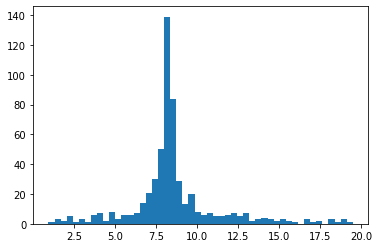

In [27]:
plt.hist(d_galac, bins=50)

In [28]:
# Randomly assign a l & b galactic coordinate to each PBH, within the LOS cone
# sample the angle from 0 to 2pi
theta = np.random.uniform(size=n_pbh) * 2 * np.pi
# sample radius correcting for annular area to make uniform
r_cyl = r_proj_los_cyl * np.sqrt(np.random.uniform(size=n_pbh)) # kpc
y_cyl = r_cyl * np.sin(theta) # kpc
x_cyl = r_cyl * np.cos(theta) # kpc

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


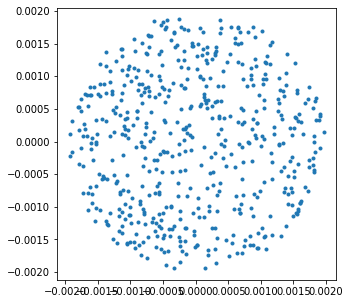

In [29]:
fig = plt.figure(figsize=(5,5))
plt.plot(x_cyl, y_cyl, '.')
plt.axes().set_aspect('equal', 'datalim')

In [30]:
# Mask out sampled PBH outside the observation cone
mask = r_cyl <= r_proj_los_cyl * d_galac / r_h_max

In [31]:
print('Number of PBH before and after light cone masking: {0} and {1}, respectively'.format(n_pbh, np.sum(mask)))

Number of PBH before and after light cone masking: 551 and 109, respectively


Text(0.5, 0, 'Galactic Coordinate Distance [kpc]')

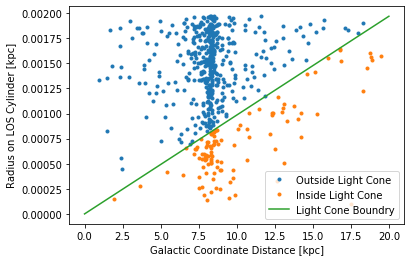

In [32]:
plt.plot(d_galac[~mask], r_cyl[~mask], '.', label='Outside Light Cone')
plt.plot(d_galac[mask], r_cyl[mask], '.', label='Inside Light Cone')
plt.plot((0,r_h_max), (0, field_of_view_radius * np.pi / 180 * r_h_max), label='Light Cone Boundry')
plt.legend(loc='best')
plt.ylabel('Radius on LOS Cylinder [kpc]')
plt.xlabel('Galactic Coordinate Distance [kpc]')

In [33]:
# Assuming small angle approximation
b_galac = r_cyl * np.sin(theta) / d_galac + b # rad
l_galac = r_cyl * np.cos(theta) / np.cos(b) / d_galac + l # rad

Text(0.5, 0, 'Galactic Coordinate Distance [kpc]')

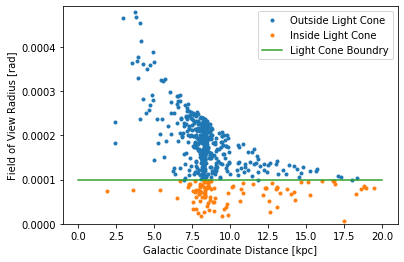

In [34]:
plt.plot(d_galac[~mask], np.sqrt((l_galac[~mask] - l)**2 + 
                                 (b_galac[~mask] - b)**2), '.', label='Outside Light Cone' )
plt.plot(d_galac[mask], np.sqrt((l_galac[mask] - l)**2 +
                                (b_galac[mask] - b)**2), '.', label='Inside Light Cone')
plt.plot((0,r_h_max),
         (field_of_view_radius * np.pi / 180, field_of_view_radius* np.pi / 180), label='Light Cone Boundry')
plt.ylim(0,5*field_of_view_radius * np.pi / 180)
plt.legend(loc='best')
plt.ylabel('Field of View Radius [rad]')
plt.xlabel('Galactic Coordinate Distance [kpc]')

Given all of this we should now have the appropriate number of black holes in our light cone, and their galactic coordinates: `l_galac`, `b_galac`, `d_galac`